<a href="https://colab.research.google.com/github/parabola01/deep_neural_networks/blob/main/GPT_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt



--2025-02-09 22:15:52--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-02-09 22:15:52 (26.4 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt


In [ ]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)

In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
def calculate_accuracy(logits, targets):
    predictions = torch.argmax(logits, dim=-1)  # Pobieramy tokeny z największym prawdopodobieństwem

    # Obsługa przypadku, gdy tensor ma tylko 1 wymiar (batch_size, ) zamiast (batch_size, seq_len)
    if predictions.dim() == 1 or targets.dim() == 1:
        predictions = predictions.view(-1)  # Spłaszczamy do 1D
        targets = targets.view(-1)  # Spłaszczamy do 1D
    else:
        # Jeśli tensor ma dwa wymiary, przycinamy do tej samej długości
        min_len = min(predictions.shape[-1], targets.shape[-1])
        predictions = predictions[:, :min_len]
        targets = targets[:, :min_len]

    correct = (predictions == targets).float()  # Sprawdzamy poprawne predykcje
    return correct.mean().item()  # Obliczamy średnią dokładność

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(vocab_size)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)

        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
            accuracies[k] = calculate_accuracy(logits, Y)

        out[split] = {
            'loss': losses.mean(),
            'accuracy': accuracies.mean()
        }

    model.train()
    return out

65


In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [ ]:
model = GPTLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
steps = []

for iter in range(max_iters):

    if iter % eval_interval == 0 or iter == max_iters - 1:
        metrics = estimate_loss()
        train_loss = metrics['train']['loss']
        val_loss = metrics['val']['loss']
        train_acc = metrics['train']['accuracy']
        val_acc = metrics['val']['accuracy']

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        steps.append(iter)

        print(f"Step {iter}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")
        print(f"              Train Accuracy {train_acc:.4f}, Val Accuracy {val_acc:.4f}")

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

10.788929 M parameters
Step 0: Train Loss 4.2221, Val Loss 4.2306
              Train Accuracy 0.0070, Val Accuracy 0.0071
Step 500: Train Loss 1.7600, Val Loss 1.9146
              Train Accuracy 0.4709, Val Accuracy 0.4336
Step 1000: Train Loss 1.3903, Val Loss 1.5987
              Train Accuracy 0.5687, Val Accuracy 0.5254
Step 1500: Train Loss 1.2644, Val Loss 1.5271
              Train Accuracy 0.6026, Val Accuracy 0.5503
Step 2000: Train Loss 1.1835, Val Loss 1.4978
              Train Accuracy 0.6247, Val Accuracy 0.5616
Step 2500: Train Loss 1.1233, Val Loss 1.4910
              Train Accuracy 0.6418, Val Accuracy 0.5667
Step 3000: Train Loss 1.0718, Val Loss 1.4804
              Train Accuracy 0.6561, Val Accuracy 0.5728
Step 3500: Train Loss 1.0179, Val Loss 1.5127
              Train Accuracy 0.6727, Val Accuracy 0.5725
Step 4000: Train Loss 0.9604, Val Loss 1.5102
              Train Accuracy 0.6897, Val Accuracy 0.5755
Step 4500: Train Loss 0.9125, Val Loss 1.5351
        

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


But with prison, I will steal for the fimker.

KING HENRY VI:
To prevent it, as I love this country's cause.

HENRY BOLINGBROKE:
I thank bhop my follow. Walk ye were so?

NORTHUMBERLAND:
My lord, I hearison! Who may love me accurse
Some chold or flights then men shows to great the cur
Ye cause who fled the trick that did princely action?
Take my captiving sound, althoughts thy crown.

RICHMOND NE:
God neit will he not make it wise this!

DUKE VINCENTIO:
Worthy Prince forth from Lord Claudio!

Lo


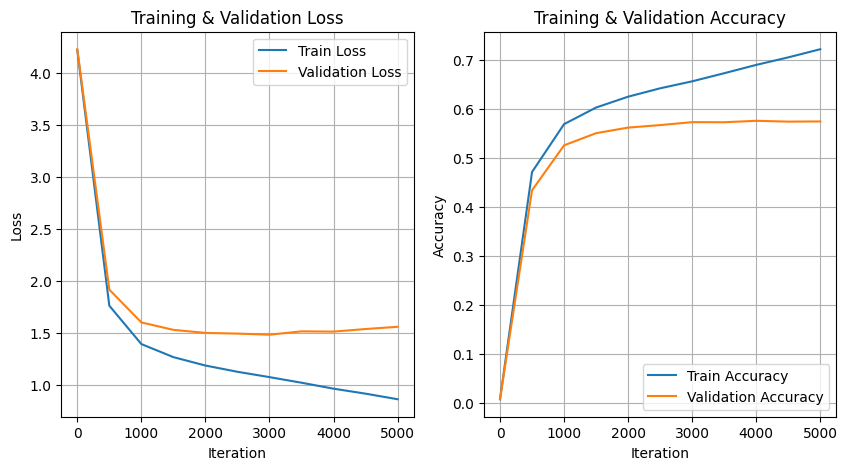

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, train_losses, label="Train Loss")
plt.plot(steps, val_losses, label="Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(steps, train_accuracies, label="Train Accuracy")
plt.plot(steps, val_accuracies, label="Validation Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()